# Distribution Networks 01 - Supply Chain assessment
*This notebook illustrates methods to assess the key variables of a distribution network.*  
***
Alessandro Tufano, Ph.D. 2021

### Import packages

In [1]:
#suppress warnings
import warnings
warnings.filterwarnings("ignore")

import os


# %% append functions path
import sys; sys.path.insert(0, '..') #add the above level with the package

# %% import packages
import pandas as pd
import matplotlib.figure
from IPython.display import display, HTML

#utilities
from analogistics.supply_chain.P8_performance_assessment.utilities_container import convertContainerISOcodeToTEUFEU
from analogistics.supply_chain.P8_performance_assessment.utilities_movements import movementStatistics

#demand assessment
from analogistics.supply_chain.P8_performance_assessment.client_demand_assessment import clientStatistics  
from analogistics.supply_chain.P8_performance_assessment.client_demand_assessment import paretoNodeClient
from analogistics.supply_chain.P8_performance_assessment.client_demand_assessment import violinPlantTerminal

#level of service
from analogistics.supply_chain.P8_performance_assessment.level_of_service_assessment import checkPlannedActual
from analogistics.supply_chain.P8_performance_assessment.level_of_service_assessment import travelTimedistribution
from analogistics.supply_chain.P8_performance_assessment.level_of_service_assessment import calculateLoS

#product mix
from analogistics.supply_chain.P8_performance_assessment.product_mix_assessment import itemSharePieGraph
from analogistics.supply_chain.P8_performance_assessment.product_mix_assessment import itemLifeCycle

#vehicle stats
from analogistics.supply_chain.P8_performance_assessment.vehicle_assessment import voyageStatistics
from analogistics.supply_chain.P8_performance_assessment.vehicle_assessment import returnFigureVoyage
from analogistics.supply_chain.P8_performance_assessment.vehicle_assessment import graphClock

#terminal stats
from analogistics.supply_chain.P8_performance_assessment.terminal_assessment import terminalStatistics

#network stats
from analogistics.supply_chain.P8_performance_assessment.network_analysis import networkStatistics

#demand assessment
from analogistics.supply_chain.P9_workload_prediction.demand_assessment import getAdvanceInPlanning





### Import data

In [2]:
# %% import data
from analogistics.data.data_generator_distribution import generateDistributionData

#random generation of distribution data
D_nodes, D_parts, D_plants, D_mov = generateDistributionData()

In [3]:
#print nodes dataframe
display(HTML(D_nodes.to_html()))

,NODECODE,DESCRIPTION,LATITUDE,LONGITUDE,CLIENT_TYPE,SIZE
0,0,NODE_0,41.812203,14.935318,CLIENT_TYPE_1,11.358783
0,1,NODE_1,41.942880,14.407796,CLIENT_TYPE_2,25.917122
0,2,NODE_2,41.767709,14.355325,CLIENT_TYPE_2,19.363885
0,3,NODE_3,41.669459,14.744534,CLIENT_TYPE_2,1.163221
0,4,NODE_4,41.769717,14.000013,CLIENT_TYPE_1,14.985466
0,5,NODE_5,41.551883,15.024442,CLIENT_TYPE_1,23.993155
0,6,NODE_6,41.599658,13.993089,CLIENT_TYPE_1,10.777871
0,7,NODE_7,41.627007,14.508249,CLIENT_TYPE_2,28.550757
0,8,NODE_8,41.933069,14.887828,CLIENT_TYPE_2,21.232508
0,9,NODE_9,41.503133,14.098095,CLIENT_TYPE_2,22.310200


In [4]:
#print parts dataframe
display(HTML(D_parts.to_html()))

,ITEMCODE,PRODUCT_FAMILY
0,0,PRODUCT_FAMILY 2
0,1,PRODUCT_FAMILY 1


In [5]:
#print plants dataframe
display(HTML(D_plants.to_html()))

,NODECODE,DESCRIPTION,LATITUDE,LONGITUDE,listClient
0,PLANT_0,NODE_PLANT_0,41.727105,15.029884,"[0, 6, 11, 17, 20, 21, 23]"
0,PLANT_1,NODE_PLANT_1,41.512404,14.710095,"[1, 2, 3, 4, 5, 7, 8, 9, 10, 12, 13, 14, 15, 16, 18, 19, 22, 24]"


In [6]:
#print movement dataframe
display(HTML(D_mov.to_html()))

,LOADING_NODE,LOADING_NODE_DESCRIPTION,LOADING_NODE_LATITUDE,LOADING_NODE_LONGITUDE,PTA_FROM,PTD_FROM,ATA_FROM,ATD_FROM,DISCHARGING_NODE,DISCHARGING_NODE_DESCRIPTION,DISCHARGING_LATITUDE,DISCHARGING_LONGITUDE,PTA_TO,PTD_TO,ATA_TO,ATD_TO,ITEMCODE,PRODUCT_FAMILY,CLIENT,VEHICLE_CODE,VOYAGE_CODE,QUANTITY,TIMESTAMP_IN,PACKAGE_DESCRIPTION,USER
0,22,NODE_22,41.942443,14.175001,2020-01-02 00:00:00.000000,2020-01-02 01:00:00.000000,2020-01-01 23:41:58.329427,2020-01-02 00:54:25.549094,16,NODE_16,41.525663,14.726993,2020-01-02 20:40:28.449595,2020-01-02 21:40:28.449595,2020-01-02 20:57:26.709643,2020-01-02 21:35:29.870671,0,PRODUCT_FAMILY 2,CLIENT 2,TRUCK 1,0,2.528182,2019-12-03 12:06:48.266675,TEU CONTAINER,USER_5
0,21,NODE_21,41.905204,14.921569,2020-01-03 02:24:17.166487,2020-01-03 03:24:17.166487,2020-01-03 02:30:33.360437,2020-01-03 03:22:12.088166,23,NODE_23,41.567439,14.880003,2020-01-03 11:46:27.517212,2020-01-03 12:46:27.517212,2020-01-03 11:09:00.230800,2020-01-03 13:06:13.272461,0,PRODUCT_FAMILY 2,CLIENT 1,TRUCK 1,0,8.864195,2019-12-31 16:16:48.464547,TEU CONTAINER,USER_4
0,3,NODE_3,41.669459,14.744534,2020-01-03 12:58:12.127610,2020-01-03 13:58:12.127610,2020-01-03 12:51:46.219366,2020-01-03 14:41:39.886760,17,NODE_17,41.651362,13.990278,2020-01-04 17:15:40.686071,2020-01-04 18:15:40.686071,2020-01-04 17:13:37.642558,2020-01-04 17:40:02.842266,0,PRODUCT_FAMILY 2,CLIENT 1,TRUCK 1,0,3.947387,2019-12-29 22:58:11.833087,TEU CONTAINER,USER_1
0,17,NODE_17,41.651362,13.990278,2020-01-04 21:21:03.195505,2020-01-04 22:21:03.195505,2020-01-04 21:41:18.793749,2020-01-04 22:25:42.368963,2,NODE_2,41.767709,14.355325,2020-01-05 09:51:10.082632,2020-01-05 10:51:10.082632,2020-01-05 09:48:21.966584,2020-01-05 11:06:05.648161,0,PRODUCT_FAMILY 2,CLIENT 2,TRUCK 1,0,4.164456,2019-12-28 17:56:46.128653,FEU CONTAINER,USER_3
0,17,NODE_17,41.651362,13.990278,2020-01-05 14:13:53.780632,2020-01-05 15:13:53.780632,2020-01-05 14:14:28.118808,2020-01-05 15:52:22.178584,18,NODE_18,41.650026,14.639292,2020-01-06 06:53:52.326228,2020-01-06 07:53:52.326228,2020-01-06 07:07:27.571292,2020-01-06 07:53:48.524843,0,PRODUCT_FAMILY 2,CLIENT 1,TRUCK 1,0,2.669079,2020-01-03 23:57:30.239822,FEU CONTAINER,USER_0
0,8,NODE_8,41.933069,14.887828,2020-01-06 07:55:08.779033,2020-01-06 08:55:08.779033,2020-01-06 07:57:19.160207,2020-01-06 09:08:24.672573,23,NODE_23,41.567439,14.880003,2020-01-06 18:10:09.464925,2020-01-06 19:10:09.464925,2020-01-06 18:24:20.284958,2020-01-06 18:55:22.056751,0,PRODUCT_FAMILY 2,CLIENT 2,TRUCK 1,0,4.647915,2020-01-04 20:17:15.743343,FEU CONTAINER,USER_1
0,4,NODE_4,41.769717,14.000013,2020-01-06 21:43:32.461407,2020-01-06 22:43:32.461407,2020-01-06 21:32:19.802615,2020-01-06 22:24:56.164025,0,NODE_0,41.812203,14.935318,2020-01-08 01:29:13.179792,2020-01-08 02:29:13.179792,2020-01-08 01:29:03.612582,2020-01-08 02:39:11.852296,1,PRODUCT_FAMILY 1,CLIENT 1,TRUCK 1,0,7.303603,2020-01-04 10:24:08.087820,FEU CONTAINER,USER_3
0,14,NODE_14,41.643440,14.376064,2020-01-08 02:37:50.345014,2020-01-08 03:37:50.345014,2020-01-08 02:36:51.968848,2020-01-08 04:03:48.295416,2,NODE_2,41.767709,14.355325,2020-01-08 05:24:51.286001,2020-01-08 06:24:51.286001,2020-01-08 05:26:35.752872,2020-01-08 06:27:41.688324,1,PRODUCT_FAMILY 1,CLIENT 1,TRUCK 1,0,5.117823,2019-12-30 14:55:55.342090,FEU CONTAINER,USER_2
0,23,NODE_23,41.567439,14.880003,2020-01-08 11:43:40.130486,2020-01-08 12:43:40.130486,2020-01-08 11:40:21.809417,2020-01-08 12:51:36.684999,10,NODE_10,41.512215,14.580288,2020-01-08 21:49:34.212725,2020-01-08 22:49:34.212725,2020-01-08 22:07:50.705330,2020-01-08 22:29:38.411266,0,PRODUCT_FAMILY 2,CLIENT 1,TRUCK 1,0,3.130797,2019-12-29 08:45:37.620485,TEU CONTAINER,USER_7
0,22,NODE_22,41.942443,14.175001,2020-01-08 22:58:32.077392,2020-01-08 23:58:32.077392,2020-01-08 22:45:06.736244,2020-01-09 00:09:02.835551,2,NODE_2,41.767709,14.355325,2020-01-09 07:51:02.038656,2020-01-09 08:51:02.038656,2020-01-09 07:40:29.858420,2020-01-09 08:55:07.840929,1,PRODUCT_FAMILY 1,

### Set data fields  
Specify the content of each column of the input data.

In [7]:
string_casestudy = 'TOY_DATA'


movementColumns= {
           'timevariable':'TIMESTAMP_IN', #colonna obbligatoria con i timestamp per ogni movimento
           'capacityField':'QUANTITY', #colonna obblicatoria che identifica la quantita' movimentata
           
           'specificItemfield':'ITEMCODE', #colonna che indica il codice di ogni singolo prodotto movimentato (ciclo di vita)
           'itemfamily' : 'PRODUCT_FAMILY', #colonna che indica la famiglia di prodotto movimentato (per market share)
           'packageFamily':'PACKAGE_DESCRIPTION', #colonna che identifica la tipologia di package utilizzato
           
           'clientfield':'DISCHARGING_NODE', # colonna che identifica il cliente servito
           'operatorfield':'USER', #colonna che identifica l'operatore
           
           'vehiclefield':'VEHICLE_CODE', #colonna che identifica il veicolo utilizzato
           'voyagefield':'VOYAGE_CODE', #colonna che identifica il codice del singolo viaggio
           
           
           'terminalfieldFrom':'LOADING_NODE', #colonna che identifica il nodo di carico
           'terminalfieldto':'DISCHARGING_NODE', #colonna che identifica il nodo di scarico
  
           }

timeColumns = {'loadingpta':'PTA_FROM',
               'loadingptd':'PTD_FROM', 
               'dischargingpta':'PTA_TO', 
               'dischargingptd':'PTD_TO', 
               'loadingata':'ATA_FROM', 
               'loadingatd':'ATD_FROM', 
               'dischargingata':'ATA_TO', 
               'dischargingatd':'ATD_TO'
               
               }

joinContainerToMov=False #join hu table and movement table on fields
codeFieldcontainerCodeHu='_id'
codeFieldcontainerCodeMov=''

### Create folder hierarchy

In [8]:
# %% create folder hierarchy
pathResults = 'C:\\Users\\aletu\\desktop'
root_path = os.path.join(pathResults,f"{string_casestudy}_results")
path_results = os.path.join(root_path,f"P8_networkAssessment")
os.makedirs(root_path, exist_ok=True)
os.makedirs(path_results, exist_ok=True)

## Global analysis  
Definition of the global statistics on the entities of the input dataset.

In [9]:
current_path = os.path.join(path_results,f"Global Statistics")
os.makedirs(current_path, exist_ok=True)
D_global = movementStatistics(D_mov,capacityField = movementColumns['capacityField']) 
D_global.to_excel(current_path+'\\movement_stats.xlsx') 
display(HTML(D_global.to_html()))

,VALUE,ACCURACY
COUNT.LOADING_NODE,25,"(1.0, 1.0)"
COUNT.LOADING_NODE_DESCRIPTION,25,"(1.0, 1.0)"
COUNT.LOADING_NODE_LATITUDE,25,"(1.0, 1.0)"
SUM.LOADING_NODE_LATITUDE,4173.21,"(1.0, 1.0)"
COUNT.LOADING_NODE_LONGITUDE,25,"(1.0, 1.0)"
SUM.LOADING_NODE_LONGITUDE,1448.92,"(1.0, 1.0)"
COUNT.PTA_FROM,100,"(1.0, 1.0)"
N.OF.DAYS.PTA_FROM,63,"(1.0, 1.0)"
FIRST.DAY.PTA_FROM,2020-01-02,"(1.0, 1.0)"
LAST.DAY.PTA_FROM,2020-03-10,"(1.0, 1.0)"


## Planning efficiency analysis

,VALUE,ACCURACY
ADVANCE_PLANNING_MEAN,6.45724,"((1.0, 1.0), 100)"
ADVANCE_PLANNING_STD,6.03281,"((1.0, 1.0), 100)"
SERIES,"0 29.495139 0 2.421528 0 4.583333 0 7.141667 0 1.594444 ... 0 0.894444 0 5.792361 0 1.511806 0 7.201389 0 5.533333 Length: 100, dtype: float64","((1.0, 1.0), 100)"


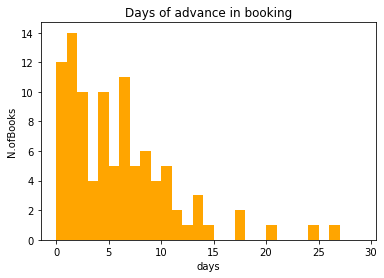

In [10]:
#calculate the gap between the order and the esecution day

if 'loadingpta' in  timeColumns.keys():
    current_path = os.path.join(path_results,f"Planning Analysis")
    os.makedirs(current_path, exist_ok=True)
    output_figure, D_global  = getAdvanceInPlanning(D_mov,loadingptafield=timeColumns['loadingpta'])
    
    #save figure
    for key in output_figure.keys():
        if isinstance(output_figure[key], matplotlib.figure.Figure):
            output_figure[key].savefig(current_path+f"\\{key}.png")
    
    #save dataframe
    D_global.to_excel(current_path+'\\planning_stats.xlsx') 
    display(HTML(D_global.to_html()))
    

## Product demand share

,PRODUCT_FAMILY,Quantity,accuracy
1,PRODUCT_FAMILY 2,51,"(1.0, 1.0)"
0,PRODUCT_FAMILY 1,49,"(1.0, 1.0)"


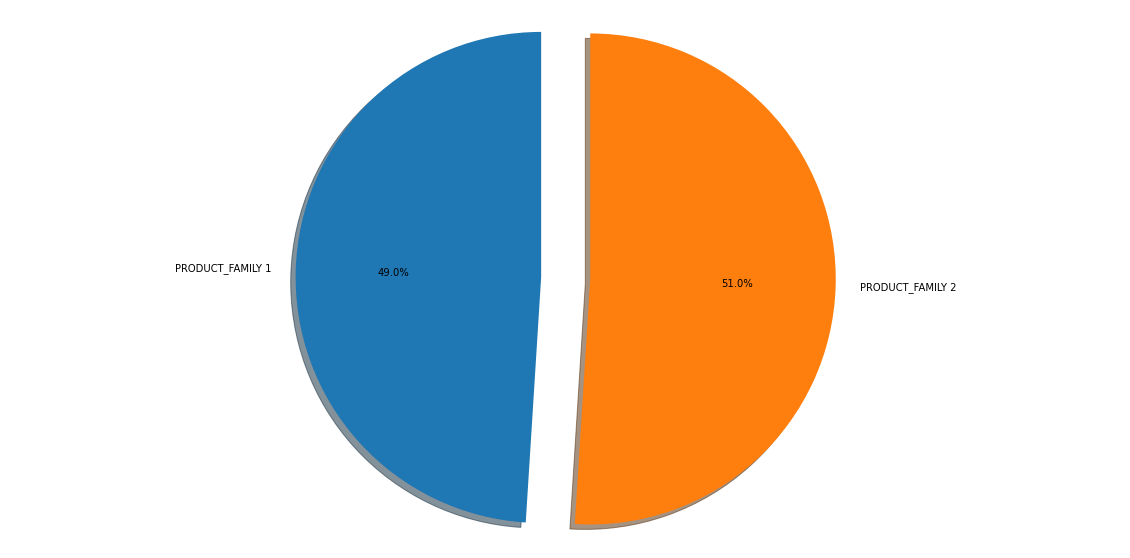

In [11]:
if 'itemfamily' in  movementColumns.keys():
    #se ho una indicazione sulle famiglie di prodotto posso realizzare un'analisi
    #della quota di mercato
    current_path = os.path.join(path_results,f"Product Analysis")
    os.makedirs(current_path, exist_ok=True)
    figPieChartItem, df_demandProductShare = itemSharePieGraph(D_mov,
                                                               capacityField = movementColumns['capacityField'],
                                                               itemfield=movementColumns['itemfamily'])
    
    #save figure
    figPieChartItem.savefig(current_path+'\\demandProductShare.png')
    
    #save dataframe
    df_demandProductShare.to_excel(current_path+'\\demandProductShare.xlsx')
    display(HTML(df_demandProductShare.to_html()))
    

## Travel time analysis

### Provisional data

,TIME_MEAN,TIME_STD,U_L_BOUND,accuracy
0,0.606271,0.337473,upperBound,"(1.0, 1.0)"
0,0.533610,0.332442,lowerBound,"(1.0, 1.0)"


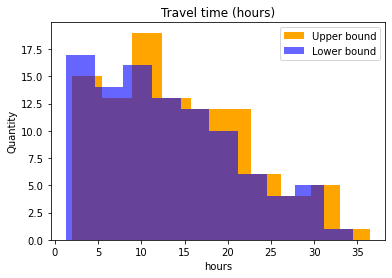

In [12]:
if all([field in timeColumns.keys() for field in ['loadingpta','loadingptd','dischargingpta', 'dischargingptd' ]]): 
    #se ho tutte le finestre temporali pianificate analizzo il caso PROVISIONAL
    
    current_path = os.path.join(path_results,f"Travel Time Analysis")
    os.makedirs(current_path, exist_ok=True)
    current_path_actual = os.path.join(current_path,f"PROVISIONAL")  
    os.makedirs(current_path_actual, exist_ok=True)
    
    imageResults, df_traveltime = travelTimedistribution(D_mov,
                                           capacityField=movementColumns['capacityField'],
                                           loadingTA=timeColumns['loadingpta'],
                                           loadingTD=timeColumns['loadingptd'],
                                           dischargingTA=timeColumns['dischargingpta'],
                                           dischargingTD=timeColumns['dischargingptd'],
                           )
    #save figure
    for key in imageResults.keys():
        imageResults[key].savefig(current_path_actual+f"\\{key}.png")
    
    #save dataframe
    df_traveltime.to_excel(current_path_actual+'\\movementsTravelTime.xlsx')
    display(HTML(df_traveltime.to_html()))
    

### Actual data

,TIME_MEAN,TIME_STD,U_L_BOUND,accuracy
0,0.605896,0.339345,upperBound,"(1.0, 1.0)"
0,0.523479,0.339962,lowerBound,"(1.0, 1.0)"


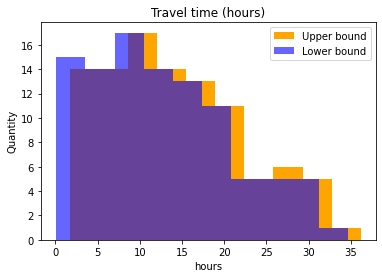

In [13]:
if all([field in timeColumns.keys() for field in ['loadingata','loadingatd','dischargingata', 'dischargingatd' ]]): 
    #se ho tutte le finestre temporali attuali analizzo il caso PROVISIONAL
    
    current_path = os.path.join(path_results,f"Travel Time Analysis")
    os.makedirs(current_path, exist_ok=True)
    current_path_actual = os.path.join(current_path,f"ACTUAL")  
    os.makedirs(current_path_actual, exist_ok=True)
    
    imageResults, df_traveltime = travelTimedistribution(D_mov,
                                           capacityField=movementColumns['capacityField'],
                                           loadingTA=timeColumns['loadingata'],
                                           loadingTD=timeColumns['loadingatd'],
                                           dischargingTA=timeColumns['dischargingata'],
                                           dischargingTD=timeColumns['dischargingatd'],
                           )
    
    for key in imageResults.keys():
        imageResults[key].savefig(current_path_actual+f"\\{key}.png")
    
    #save dataframe
    df_traveltime.to_excel(current_path_actual+'\\movementsTravelTime.xlsx')
    display(HTML(df_traveltime.to_html()))

## Level of Service

,0,1
0,1.0,1.0


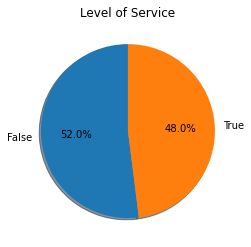

In [14]:
if all( column in timeColumns.keys() for column in ['loadingptd','dischargingpta',
                                                        'loadingatd','dischargingata']):
    current_path = os.path.join(path_results,f"Travel Time Analysis")
    os.makedirs(current_path, exist_ok=True)
    output_figure, coverages=   calculateLoS(D_mov,
                               capacityField=movementColumns['capacityField'],
                                timeColumns=timeColumns
                               )
    for key in output_figure.keys():
        output_figure[key].savefig(current_path+f"\\{key}.png")
    
    #save dataframe
    coverages.to_excel(current_path+f"\\Level_of_service_coverages.xlsx")
    display(HTML(coverages.to_html()))

## Product lifecycle

**** DEFINE D MOV IN/OUT ****
**** DEFINE D MOV IN/OUT ****


,index,LOADING_NODE,LOADING_NODE_DESCRIPTION,LOADING_NODE_LATITUDE,LOADING_NODE_LONGITUDE,PTA_FROM,PTD_FROM,ATA_FROM,ATD_FROM,DISCHARGING_NODE,DISCHARGING_NODE_DESCRIPTION,DISCHARGING_LATITUDE,DISCHARGING_LONGITUDE,PTA_TO,PTD_TO,ATA_TO,ATD_TO,ITEMCODE,PRODUCT_FAMILY,CLIENT,VEHICLE_CODE,VOYAGE_CODE,QUANTITY,TIMESTAMP_IN,PACKAGE_DESCRIPTION,USER,accuracy
0,0,22,NODE_22,41.942443,14.175001,2020-01-02 00:00:00.000000,2020-01-02 01:00:00.000000,2020-01-01 23:41:58.329427,2020-01-02 00:54:25.549094,16,NODE_16,41.525663,14.726993,2020-01-02 20:40:28.449595,2020-01-02 21:40:28.449595,2020-01-02 20:57:26.709643,2020-01-02 21:35:29.870671,0,PRODUCT_FAMILY 2,CLIENT 2,TRUCK 1,0,2.528182,2019-12-03 12:06:48.266675,TEU CONTAINER,USER_5,"(1.0, 1.0)"
1,0,21,NODE_21,41.905204,14.921569,2020-01-03 02:24:17.166487,2020-01-03 03:24:17.166487,2020-01-03 02:30:33.360437,2020-01-03 03:22:12.088166,23,NODE_23,41.567439,14.880003,2020-01-03 11:46:27.517212,2020-01-03 12:46:27.517212,2020-01-03 11:09:00.230800,2020-01-03 13:06:13.272461,0,PRODUCT_FAMILY 2,CLIENT 1,TRUCK 1,0,8.864195,2019-12-31 16:16:48.464547,TEU CONTAINER,USER_4,"(1.0, 1.0)"
2,0,3,NODE_3,41.669459,14.744534,2020-01-03 12:58:12.127610,2020-01-03 13:58:12.127610,2020-01-03 12:51:46.219366,2020-01-03 14:41:39.886760,17,NODE_17,41.651362,13.990278,2020-01-04 17:15:40.686071,2020-01-04 18:15:40.686071,2020-01-04 17:13:37.642558,2020-01-04 17:40:02.842266,0,PRODUCT_FAMILY 2,CLIENT 1,TRUCK 1,0,3.947387,2019-12-29 22:58:11.833087,TEU CONTAINER,USER_1,"(1.0, 1.0)"
3,0,17,NODE_17,41.651362,13.990278,2020-01-04 21:21:03.195505,2020-01-04 22:21:03.195505,2020-01-04 21:41:18.793749,2020-01-04 22:25:42.368963,2,NODE_2,41.767709,14.355325,2020-01-05 09:51:10.082632,2020-01-05 10:51:10.082632,2020-01-05 09:48:21.966584,2020-01-05 11:06:05.648161,0,PRODUCT_FAMILY 2,CLIENT 2,TRUCK 1,0,4.164456,2019-12-28 17:56:46.128653,FEU CONTAINER,USER_3,"(1.0, 1.0)"
4,0,17,NODE_17,41.651362,13.990278,2020-01-05 14:13:53.780632,2020-01-05 15:13:53.780632,2020-01-05 14:14:28.118808,2020-01-05 15:52:22.178584,18,NODE_18,41.650026,14.639292,2020-01-06 06:53:52.326228,2020-01-06 07:53:52.326228,2020-01-06 07:07:27.571292,2020-01-06 07:53:48.524843,0,PRODUCT_FAMILY 2,CLIENT 1,TRUCK 1,0,2.669079,2020-01-03 23:57:30.239822,FEU CONTAINER,USER_0,"(1.0, 1.0)"
5,0,8,NODE_8,41.933069,14.887828,2020-01-06 07:55:08.779033,2020-01-06 08:55:08.779033,2020-01-06 07:57:19.160207,2020-01-06 09:08:24.672573,23,NODE_23,41.567439,14.880003,2020-01-06 18:10:09.464925,2020-01-06 19:10:09.464925,2020-01-06 18:24:20.284958,2020-01-06 18:55:22.056751,0,PRODUCT_FAMILY 2,CLIENT 2,TRUCK 1,0,4.647915,2020-01-04 20:17:15.743343,FEU CONTAINER,USER_1,"(1.0, 1.0)"
6,0,23,NODE_23,41.567439,14.880003,2020-01-08 11:43:40.130486,2020-01-08 12:43:40.130486,2020-01-08 11:40:21.809417,2020-01-08 12:51:36.684999,10,NODE_10,41.512215,14.580288,2020-01-08 21:49:34.212725,2020-01-08 22:49:34.212725,2020-01-08 22:07:50.705330,2020-01-08 22:29:38.411266,0,PRODUCT_FAMILY 2,CLIENT 1,TRUCK 1,0,3.130797,2019-12-29 08:45:37.620485,TEU CONTAINER,USER_7,"(1.0, 1.0)"
7,0,0,NODE_0,41.812203,14.935318,2020-01-10 03:58:49.192985,2020-01-10 04:58:49.192985,2020-01-10 03:37:06.870137,2020-01-10 05:28:50.608834,2,NODE_2,41.767709,14.355325,2020-01-10 18:58:26.495575,2020-01-10 19:58:26.495575,2020-01-10 19:13:03.631452,2020-01-10 19:53:43.912681,0,PRODUCT_FAMILY 2,CLIENT 2,TRUCK 1,0,3.598379,2020-01-03 08:07:33.563912,TEU CONTAINER,USER_7,"(1.0, 1.0)"
8,0,21,NODE_21,41.905204,14.921569,2020-01-11 00:16:45.260226,2020-01-11 01:16:45.260226,2020-01-10 23:47:43.604633,2020-01-11 01:09:36.102812,8,NODE_8,41.933069,14.887828,2020-01-11 02:58:33.935750,2020-01-11 03:58:33.935750,2020-01-11 02:34:56.140579,2020-01-11 04:04:46.958236,0,PRODUCT_FAMILY 2,CLIENT 2,TRUCK 1,0,7.976087,2020-01-08 04:29:49.105252,TEU CONTAINER,USER_2,"(1.0, 1.0)"
9,0,2,NODE_2,41.767709,14.355325,2020-01-11 06:05:38.881490,2020-01-11 07:05:38.881490,2020-01-11 05:58:06.715812,2020-01-11 06:59:22.159319,23,NOD

,index,LOADING_NODE,LOADING_NODE_DESCRIPTION,LOADING_NODE_LATITUDE,LOADING_NODE_LONGITUDE,PTA_FROM,PTD_FROM,ATA_FROM,ATD_FROM,DISCHARGING_NODE,DISCHARGING_NODE_DESCRIPTION,DISCHARGING_LATITUDE,DISCHARGING_LONGITUDE,PTA_TO,PTD_TO,ATA_TO,ATD_TO,ITEMCODE,PRODUCT_FAMILY,CLIENT,VEHICLE_CODE,VOYAGE_CODE,QUANTITY,TIMESTAMP_IN,PACKAGE_DESCRIPTION,USER,accuracy
0,0,4,NODE_4,41.769717,14.000013,2020-01-06 21:43:32.461407,2020-01-06 22:43:32.461407,2020-01-06 21:32:19.802615,2020-01-06 22:24:56.164025,0,NODE_0,41.812203,14.935318,2020-01-08 01:29:13.179792,2020-01-08 02:29:13.179792,2020-01-08 01:29:03.612582,2020-01-08 02:39:11.852296,1,PRODUCT_FAMILY 1,CLIENT 1,TRUCK 1,0,7.303603,2020-01-04 10:24:08.087820,FEU CONTAINER,USER_3,"(1.0, 1.0)"
1,0,14,NODE_14,41.643440,14.376064,2020-01-08 02:37:50.345014,2020-01-08 03:37:50.345014,2020-01-08 02:36:51.968848,2020-01-08 04:03:48.295416,2,NODE_2,41.767709,14.355325,2020-01-08 05:24:51.286001,2020-01-08 06:24:51.286001,2020-01-08 05:26:35.752872,2020-01-08 06:27:41.688324,1,PRODUCT_FAMILY 1,CLIENT 1,TRUCK 1,0,5.117823,2019-12-30 14:55:55.342090,FEU CONTAINER,USER_2,"(1.0, 1.0)"
2,0,22,NODE_22,41.942443,14.175001,2020-01-08 22:58:32.077392,2020-01-08 23:58:32.077392,2020-01-08 22:45:06.736244,2020-01-09 00:09:02.835551,2,NODE_2,41.767709,14.355325,2020-01-09 07:51:02.038656,2020-01-09 08:51:02.038656,2020-01-09 07:40:29.858420,2020-01-09 08:55:07.840929,1,PRODUCT_FAMILY 1,CLIENT 1,TRUCK 1,0,9.777949,2020-01-08 17:38:17.468809,FEU CONTAINER,USER_4,"(1.0, 1.0)"
3,0,0,NODE_0,41.812203,14.935318,2020-01-09 09:39:00.891143,2020-01-09 10:39:00.891143,2020-01-09 09:56:17.327947,2020-01-09 10:27:18.393683,1,NODE_1,41.942880,14.407796,2020-01-10 02:24:35.667759,2020-01-10 03:24:35.667759,2020-01-10 02:27:44.890579,2020-01-10 03:19:13.817942,1,PRODUCT_FAMILY 1,CLIENT 2,TRUCK 1,0,2.196663,2020-01-07 15:28:04.489325,FEU CONTAINER,USER_1,"(1.0, 1.0)"
4,0,7,NODE_7,41.627007,14.508249,2020-01-11 19:29:53.846735,2020-01-11 20:29:53.846735,2020-01-11 19:18:46.956048,2020-01-11 20:08:15.137289,2,NODE_2,41.767709,14.355325,2020-01-11 23:17:47.052801,2020-01-12 00:17:47.052801,2020-01-11 23:03:38.510729,2020-01-12 00:35:36.177563,1,PRODUCT_FAMILY 1,CLIENT 2,TRUCK 1,0,8.403520,2020-01-10 18:36:48.132044,FEU CONTAINER,USER_1,"(1.0, 1.0)"
5,0,8,NODE_8,41.933069,14.887828,2020-01-12 02:27:47.401226,2020-01-12 03:27:47.401226,2020-01-12 02:23:47.924451,2020-01-12 03:26:52.192004,24,NODE_24,41.942973,14.000289,2020-01-12 22:25:02.057485,2020-01-12 23:25:02.057485,2020-01-12 22:20:34.955675,2020-01-12 23:52:54.311306,1,PRODUCT_FAMILY 1,CLIENT 2,TRUCK 1,0,1.023648,2020-01-02 18:10:00.696423,FEU CONTAINER,USER_7,"(1.0, 1.0)"
6,0,4,NODE_4,41.769717,14.000013,2020-01-12 23:46:54.745337,2020-01-13 00:46:54.745337,2020-01-12 23:45:26.136290,2020-01-13 00:16:17.727590,3,NODE_3,41.669459,14.744534,2020-01-13 23:12:30.398422,2020-01-14 00:12:30.398422,2020-01-13 23:15:19.078859,2020-01-14 00:14:49.988660,1,PRODUCT_FAMILY 1,CLIENT 2,TRUCK 1,0,1.888371,2020-01-04 01:05:23.822780,TEU CONTAINER,USER_6,"(1.0, 1.0)"
7,0,18,NODE_18,41.650026,14.639292,2020-01-16 08:10:59.440192,2020-01-16 09:10:59.440192,2020-01-16 07:40:43.339179,2020-01-16 09:40:03.100242,5,NODE_5,41.551883,15.024442,2020-01-16 16:38:02.956660,2020-01-16 17:38:02.956660,2020-01-16 16:54:10.674767,2020-01-16 17:20:27.643817,1,PRODUCT_FAMILY 1,CLIENT 1,TRUCK 1,0,7.625377,2020-01-09 23:13:18.986591,TEU CONTAINER,USER_0,"(1.0, 1.0)"
8,0,8,NODE_8,41.933069,14.887828,2020-01-17 09:41:42.106683,2020-01-17 10:41:42.106683,2020-01-17 09:54:28.210792,2020-01-17 10:44:49.392247,6,NODE_6,41.599658,13.993089,2020-01-18 21:10:17.784387,2020-01-18 22:10:17.784387,2020-01-18 21:24:37.628472,2020-01-18 22:03:56.028300,1,PRODUCT_FAMILY 1,CLIENT 1,TRUCK 1,0,2.481396,2020-01-12 17:58:20.944473,FEU CONTAINER,USER_5,"(1.0, 1.0)"
9,0,4,NODE_4,41.769717,14.000013,2020-01-19 00:21:43.336959,2020-01-19 01:21:43.336959,2020-01-19 00:50:52.618513,2020-01-19 00:53:48.437187,15,NODE_15,41.821292,1

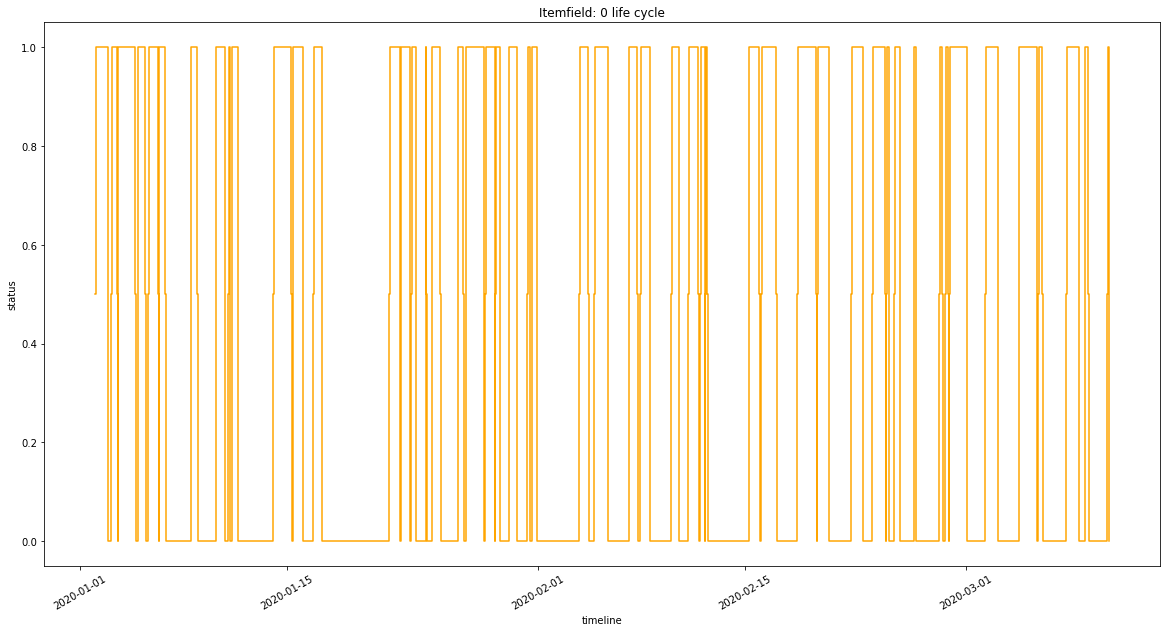

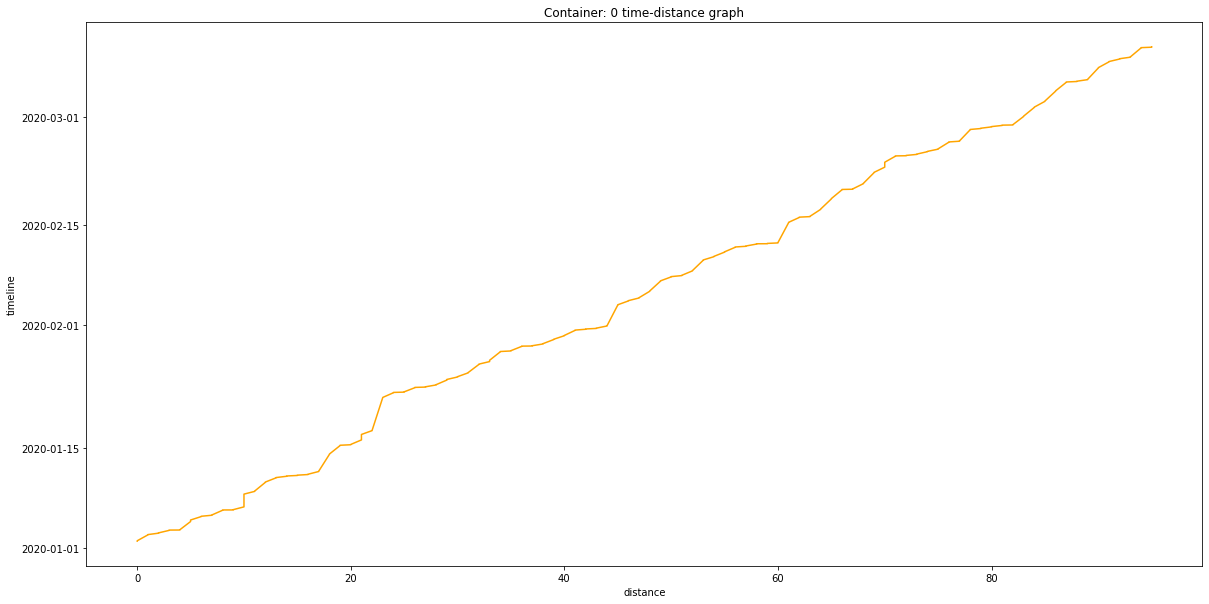

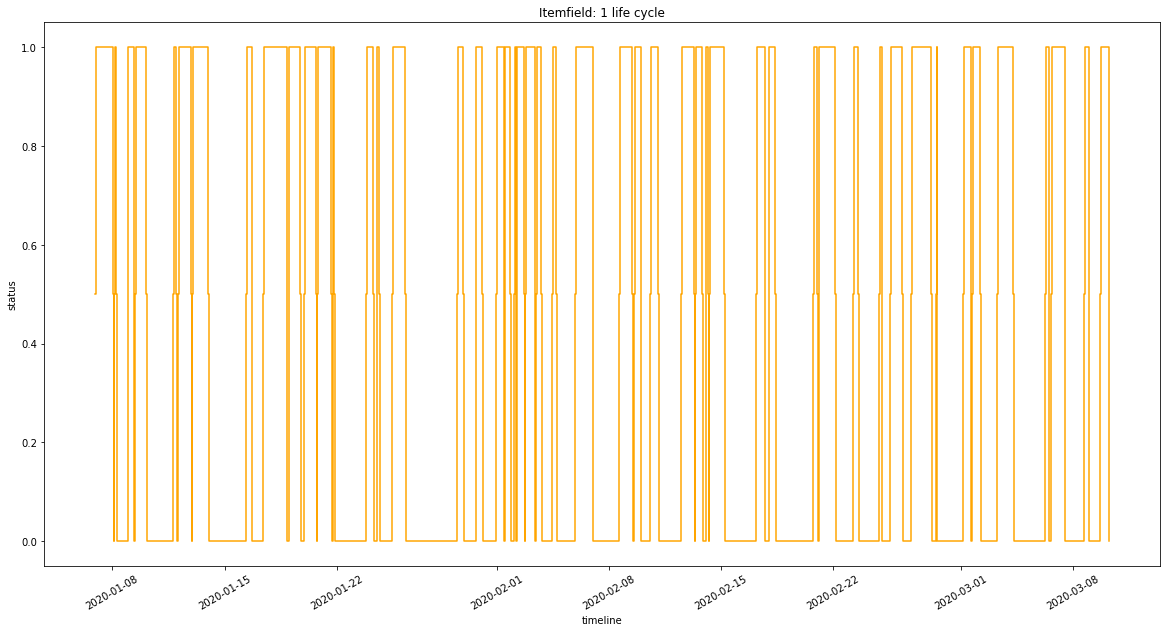

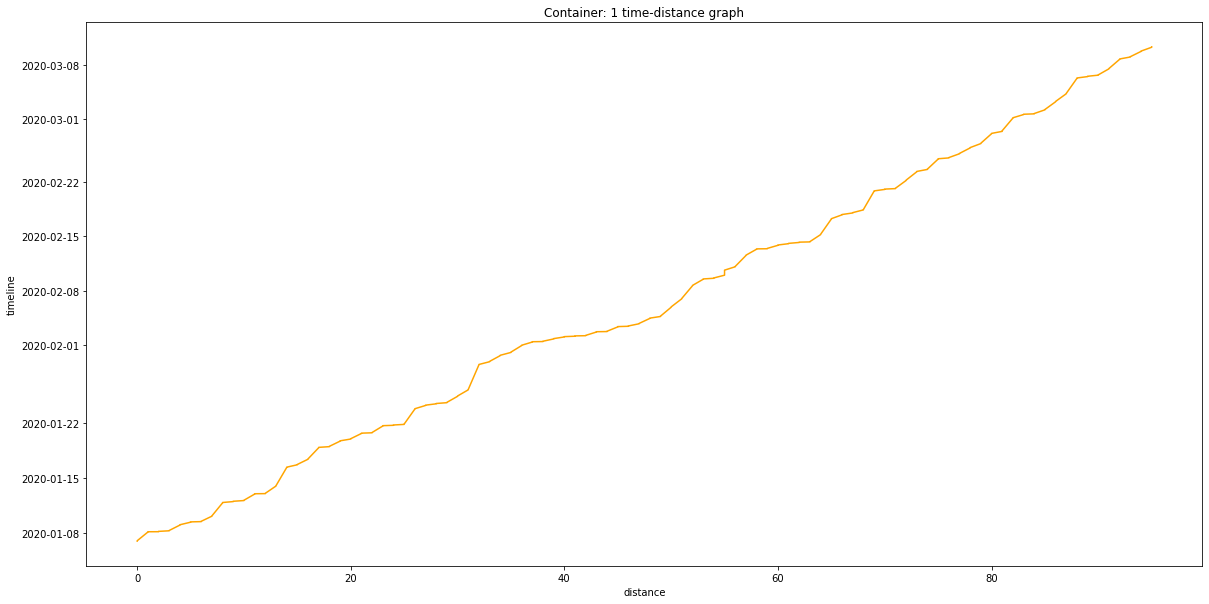

In [15]:
if all([field in movementColumns.keys() for field in ['terminalfieldFrom','terminalfieldto','specificItemfield']]):
    current_path = os.path.join(path_results,f"Product Life Cycle Analysis")
    os.makedirs(current_path, exist_ok=True)
    imageResults, df_results = itemLifeCycle(D_mov,itemfield=movementColumns['specificItemfield'], 
                  locationfrom=movementColumns['terminalfieldFrom'],
                  locationto=movementColumns['terminalfieldto'],
                  capacityField=movementColumns['capacityField'],
                  timeColumns=timeColumns,
                  sortTimefield='PTA_FROM',
                  numItemTosave=5)
    
    
    

    for key in imageResults.keys():
        imageResults[key].savefig(current_path+f"\\{key}.png")
        
    # salvo dataframe
    for key in df_results.keys():
        df_results[key].to_excel(current_path+f"\\{key}.xlsx")
        display(HTML(df_results[key].to_html()))

## Client statistics

,DISCHARGING_NODE,FEU CONTAINER,TEU CONTAINER,TotalOrders,accuracy
0,0,3.0,5.0,8,"(1.0, 1.0)"
1,1,2.0,0.0,2,"(1.0, 1.0)"
2,2,5.0,2.0,7,"(1.0, 1.0)"
3,3,2.0,1.0,3,"(1.0, 1.0)"
4,4,5.0,4.0,9,"(1.0, 1.0)"
5,5,3.0,2.0,5,"(1.0, 1.0)"
6,6,5.0,0.0,5,"(1.0, 1.0)"
7,7,4.0,1.0,5,"(1.0, 1.0)"
8,8,2.0,3.0,5,"(1.0, 1.0)"
9,9,1.0,0.0,1,"(1.0, 1.0)"


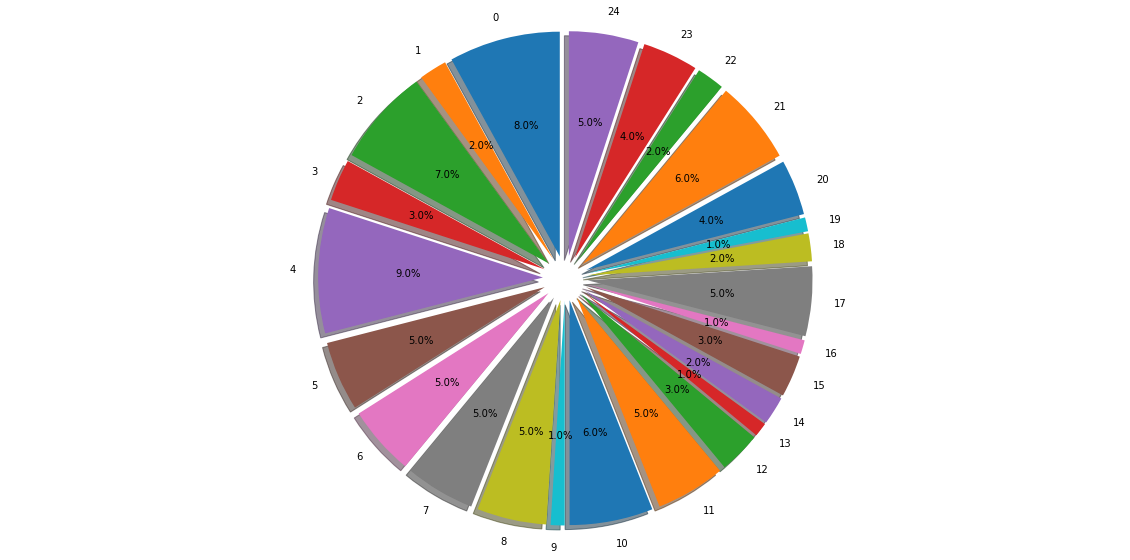

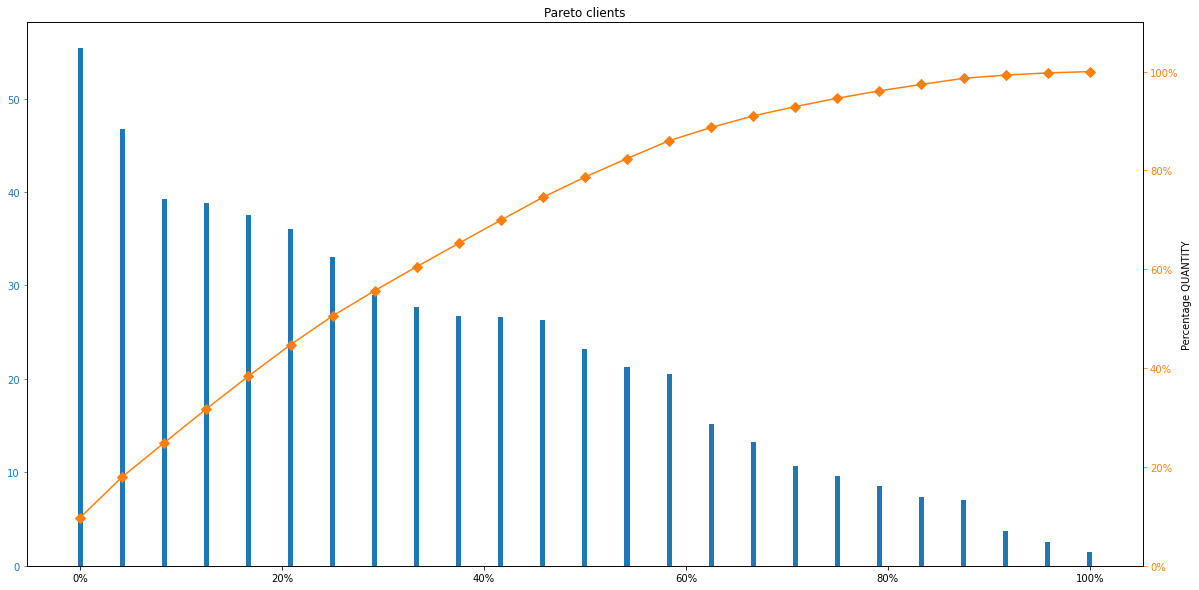

In [16]:
#represent the share of each client and the pareto curve
if all([field in movementColumns.keys() for field in ['clientfield','packageFamily']]):        
    current_path = os.path.join(path_results,f"Client Analysis")
    os.makedirs(current_path, exist_ok=True)
    
    imageResults, df_results = clientStatistics(D_mov, 
                           clientfield=movementColumns['clientfield'],
                           itemfamily=movementColumns['packageFamily'],
                           capacityfield=movementColumns['capacityField'])
    
    #salvo immagini
    for key in imageResults.keys():
            imageResults[key].savefig(current_path+f"\\{key}.png")
            
    # salvo dataframe
    df_results.to_excel(current_path+f"\\clientStatistics.xlsx")
    display(HTML(df_results.to_html()))

,0,1
0,1.0,1.0


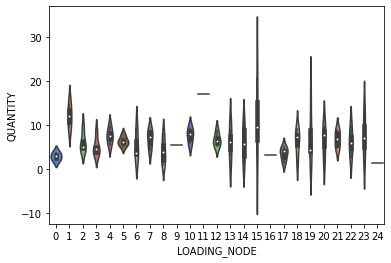

In [17]:
#violin chart of the number of clients served by each plant field
if all([field in movementColumns.keys() for field in ['clientfield','terminalfieldto']]):
    output_figure, output_df = violinPlantTerminal(D_mov,
                                                plantField=movementColumns['terminalfieldFrom'],
                                                clientField=movementColumns['clientfield'],
                                                capacityField=movementColumns['capacityField'])
    #salvo immagini
    for key in output_figure.keys():
            output_figure[key].savefig(current_path+f"\\{key}.png")
            
    # salvo dataframe
    for key in output_df.keys():
            output_df[key].to_excel(current_path+f"\\{key}.xlsx")
            display(HTML(output_df[key].to_html()))

## Vehicle analysis

**** DEFINE D MOV IN/OUT ****
**** DEFINE ROUTES  ****
**** INVENTORY ESTIMATE  ****
==estimate inventory voyage TRUCK 1, with 200 movements
**** DEFINE D MOV IN/OUT ****
**** DEFINE ROUTES  ****
**** INVENTORY ESTIMATE  ****
==estimate inventory voyage TRUCK 1, with 189 movements
**** DEFINE D MOV IN/OUT ****
**** DEFINE ROUTES  ****
**** INVENTORY ESTIMATE  ****
==estimate inventory voyage TRUCK 1, with 200 movements
**** DEFINE D MOV IN/OUT ****
**** DEFINE ROUTES  ****
**** INVENTORY ESTIMATE  ****
==estimate inventory voyage TRUCK 1, with 189 movements


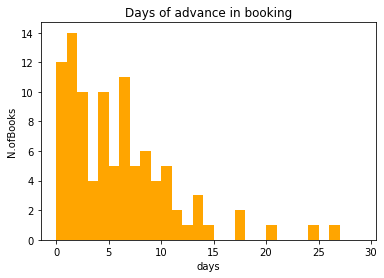

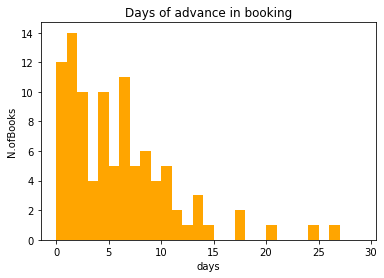

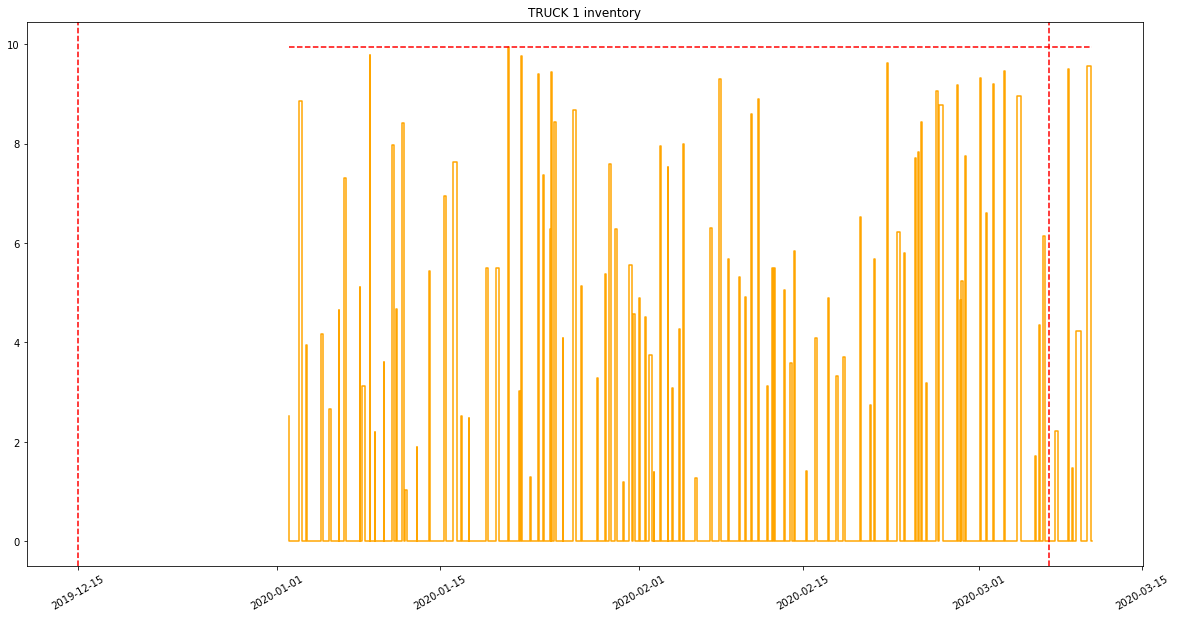

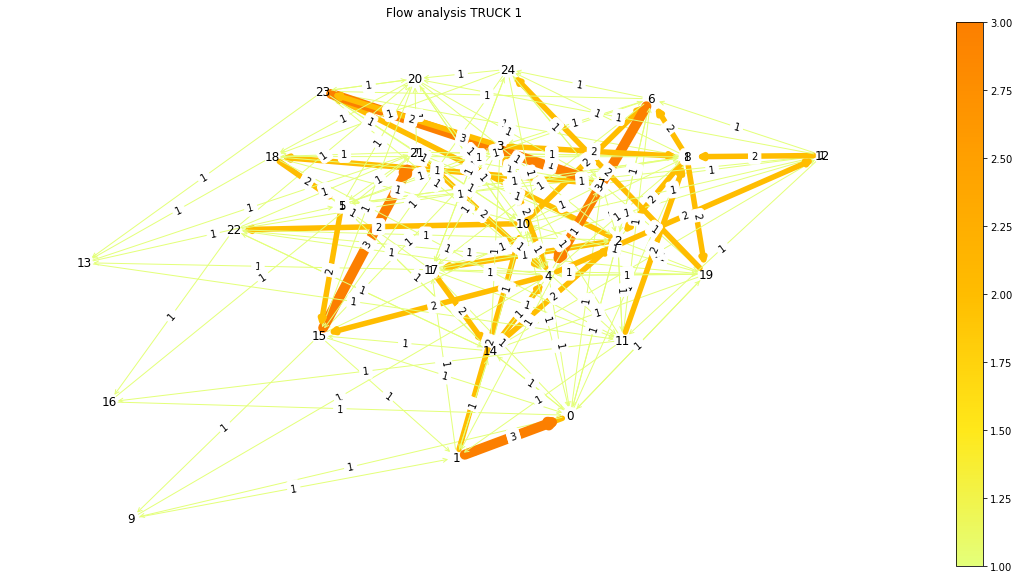

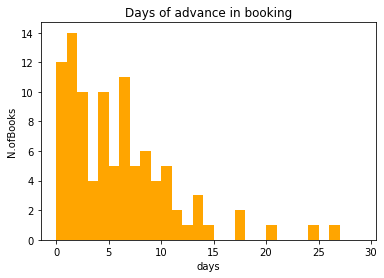

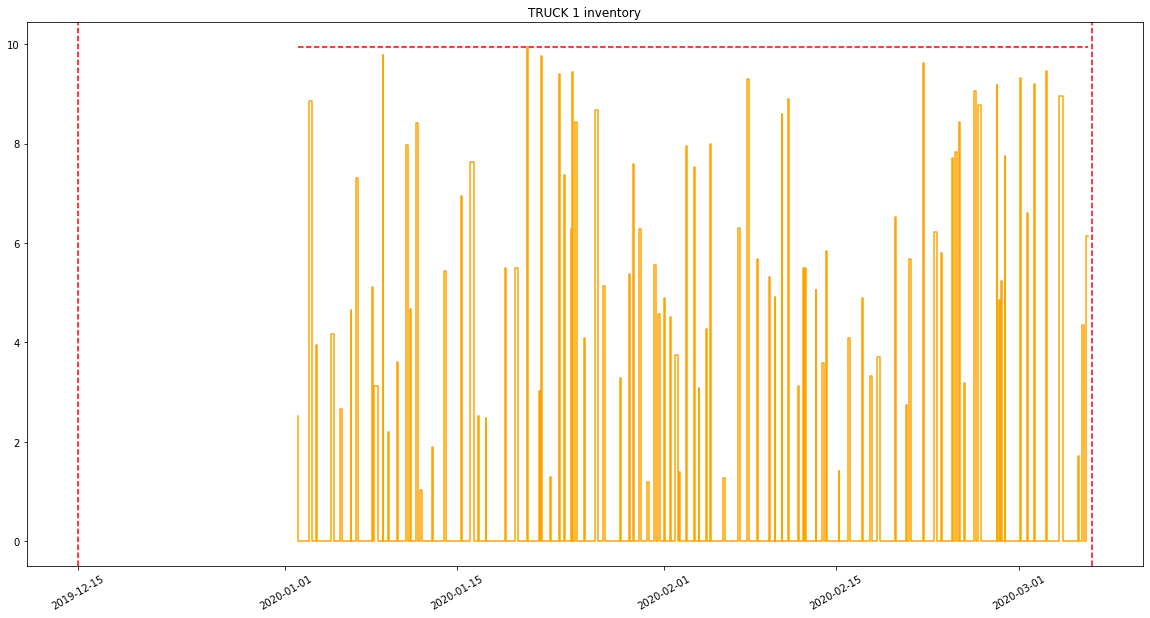

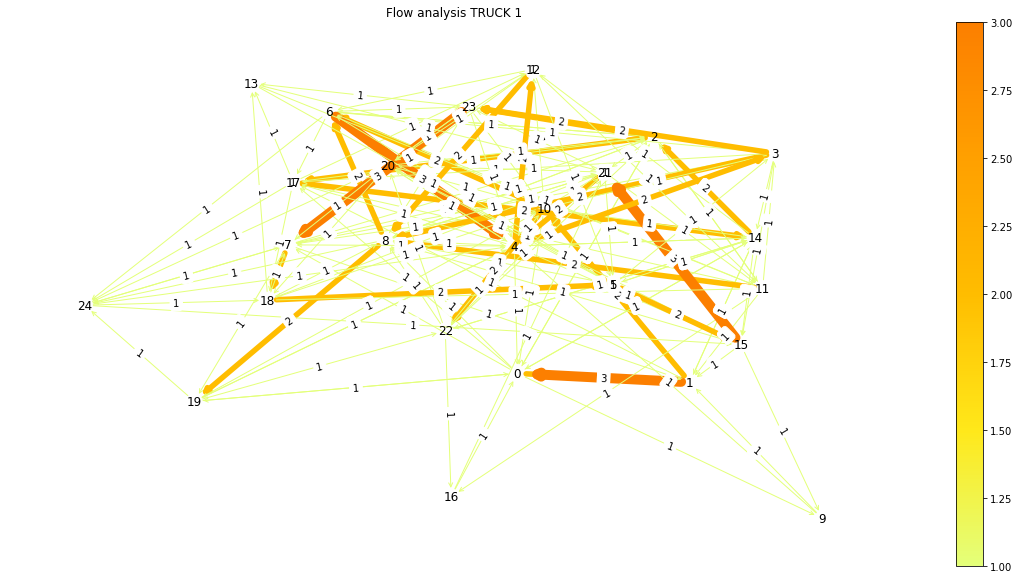

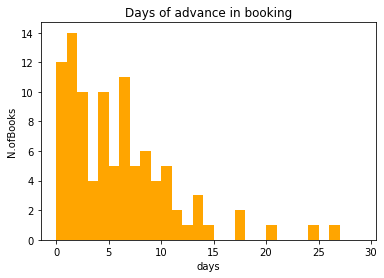

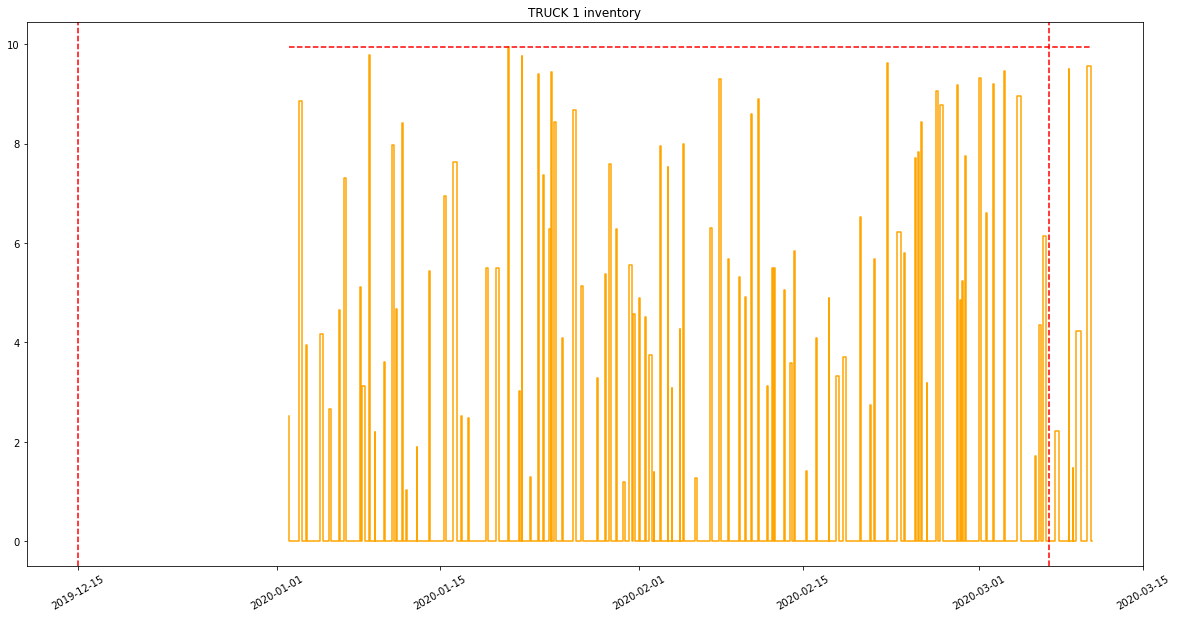

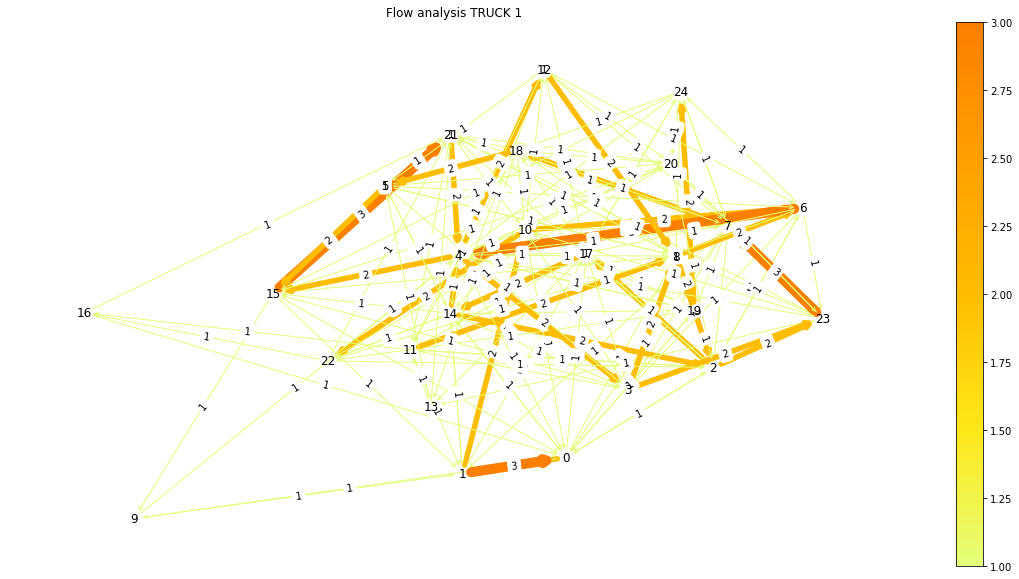

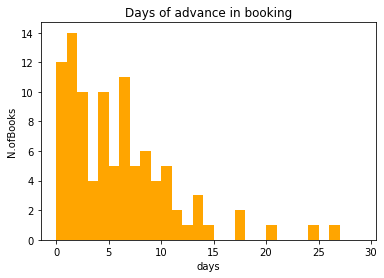

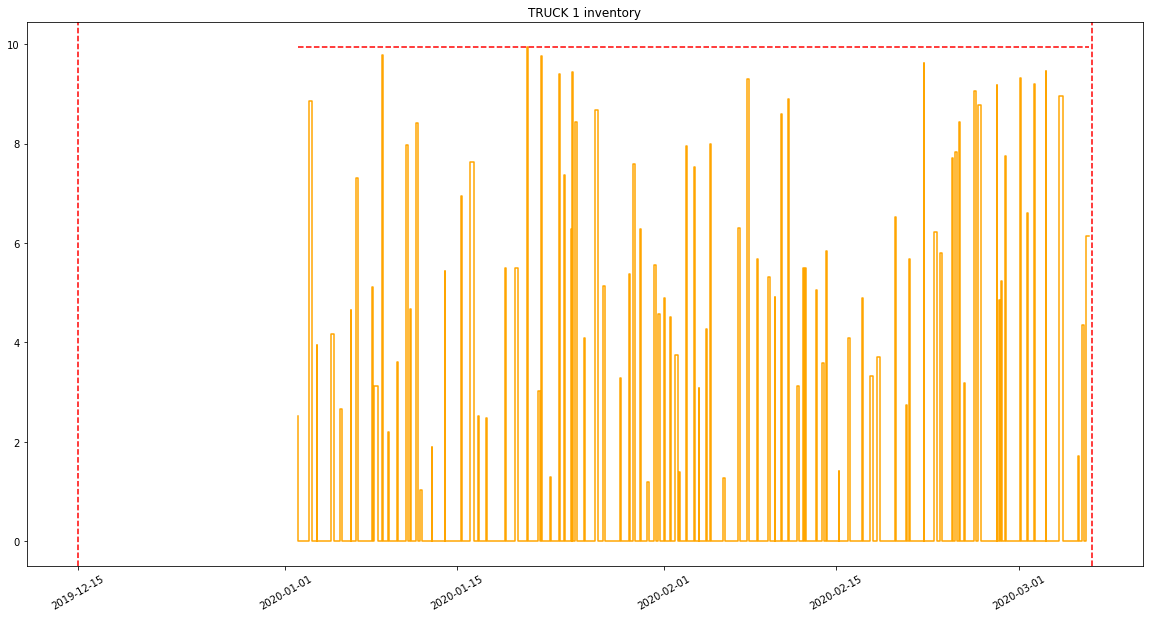

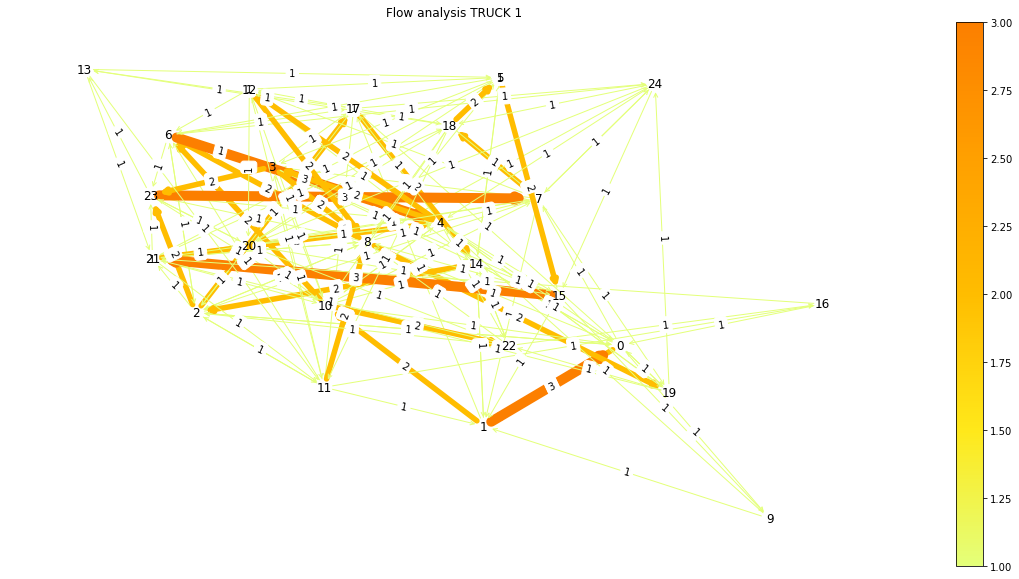

In [18]:
# %% VEHICLE STATISTICS
neededcolumns_time= ['loadingpta','loadingptd','dischargingpta', 
        'dischargingptd']
neededcolumns = ['terminalfieldFrom','terminalfieldto','capacityField']

if (all([field in movementColumns.keys() for field in neededcolumns]) &
    all([field in timeColumns.keys() for field in neededcolumns_time])): 
    # identifico estremi temporali dell'analisi
    firstPlanningDay=min(D_mov[movementColumns['timevariable']].dt.date)
    lastPlanningDay=max(D_mov[movementColumns['timevariable']].dt.date)
    _, df_advance  = getAdvanceInPlanning(D_mov,loadingptafield=timeColumns['loadingpta'])
    mean_advanceInPlanning=df_advance.loc['ADVANCE_PLANNING_MEAN']['VALUE']
    std_advanceInPlanning=df_advance.loc['ADVANCE_PLANNING_STD']['VALUE']
    lowerBoundDataCensored=firstPlanningDay+pd.Timedelta(days=(mean_advanceInPlanning+std_advanceInPlanning))
            
    
    current_path = os.path.join(path_results,f"Voyage Analysis")
    os.makedirs(current_path, exist_ok=True)
    
    
    #verifico che dati ho a disposizione
    casiDaAnalizzare=[]
    if all([field in timeColumns.keys() for field in ['loadingpta','loadingptd','dischargingpta', 'dischargingptd' ]]): 
        casiDaAnalizzare.append('PROVISIONAL')
    if all([field in timeColumns.keys() for field in ['loadingata','loadingatd','dischargingata', 'dischargingatd' ]]): 
        casiDaAnalizzare.append('ACTUAL')

    for actual in casiDaAnalizzare:
        current_path_actual = os.path.join(current_path,f"{actual}")   
        os.makedirs(current_path_actual, exist_ok=True)
        
        for censored in ['CENSORED','COMPLETE']:
            
            if censored=='CENSORED': 
                censoredData=True
                current_path_censored = os.path.join(current_path_actual,f"CENSORED")
                os.makedirs(current_path_censored, exist_ok=True)
            else:
                censoredData=False
                current_path_censored = os.path.join(current_path_actual,f"COMPLETE")
                os.makedirs(current_path_censored, exist_ok=True)
            
            
        
        
            #ricostruisco le rotte
            D_route,  D_arcs_route, D_coverages  = voyageStatistics(     D_mov,
                                                timefield=movementColumns['timevariable'],
                                                locfrom = movementColumns['terminalfieldFrom'],
                                                locto= movementColumns['terminalfieldto'],
                                                timeColumns = timeColumns,
                                                capacityField=movementColumns['capacityField'],
                                                voyagefield =movementColumns['vehiclefield'],
                                                censoredData=censoredData,
                                                actual=actual)
            # salvo dataframe
            D_coverages.to_excel(current_path_censored+f"\\coverages.xlsx")  
            D_route.to_excel(current_path_censored+f"\\movementRoute.xlsx")    
            D_arcs_route.to_excel(current_path_censored+f"\\arcRoute.xlsx") 
                    
            if actual=='PROVISIONAL':
                sortTimefield='PTD'
            elif actual=='ACTUAL':
                sortTimefield='ATD'
            #salvo le immagini dei mezzi
            if len(D_route)>1:
                figure_results = returnFigureVoyage(D_route, D_arcs_route, 
                                                    lastPlanningDay=lastPlanningDay, lowerBoundDataCensored=lowerBoundDataCensored, 
                                                    filteringfield=movementColumns['vehiclefield'],
                                                    sortTimefield=sortTimefield)
                #salvo immagini
                for key in figure_results.keys():
                        figure_results[key].savefig(current_path_censored+f"\\{key}.png")

## Information analysis

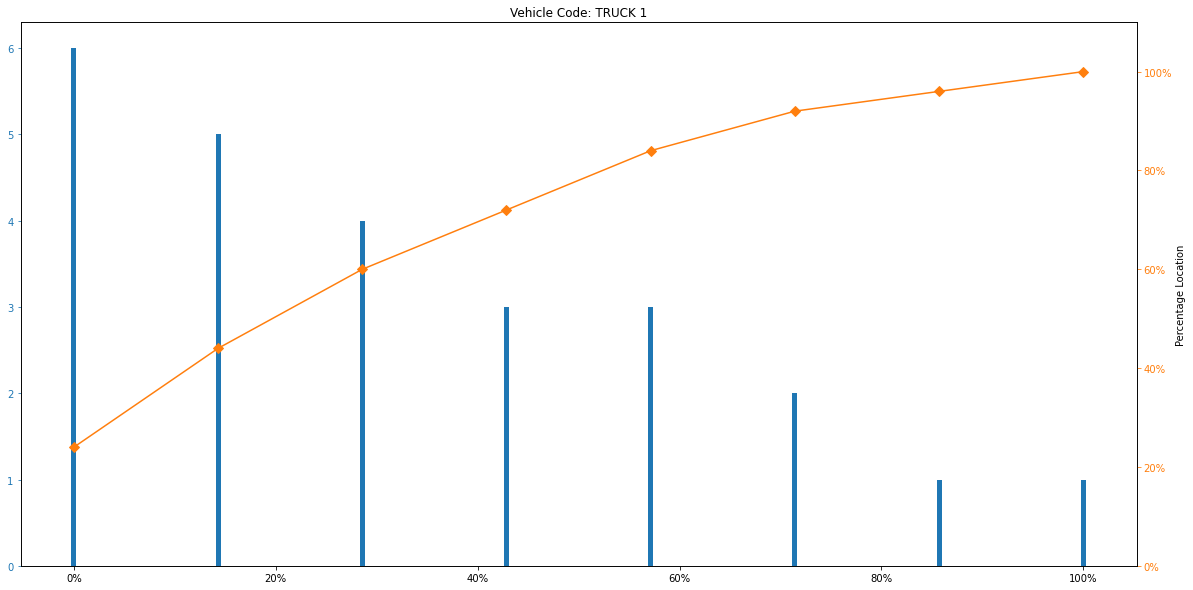

In [20]:
neededcolumns_time= []
neededcolumns = ['operatorfield','terminalfieldFrom','terminalfieldto','capacityField','vehiclefield']                
if (all([field in movementColumns.keys() for field in neededcolumns])):
               current_path = os.path.join(path_results,f"Information Analysis")
               os.makedirs(current_path, exist_ok=True)
               
               outputfigure, output_df = paretoNodeClient(D_mov, 
                    clientfield=movementColumns['operatorfield'], 
                    locationfromfield=movementColumns['terminalfieldFrom'],
                    locationtofield=movementColumns['terminalfieldto'],
                    vehiclefield=movementColumns['vehiclefield'],
                    capacityField=movementColumns['capacityField'],
                    )
    
               #salvo immagini
               for key in outputfigure.keys():
                        outputfigure[key].savefig(current_path+f"\\{key}.png")
                        
               # salvo dataframe
               for key in output_df.keys():
                    output_df[key].to_excel(current_path+f"\\{key}.xlsx")

## Terminal statistics

In [22]:
neededcolumns_time= ['loadingpta','loadingptd','dischargingpta', 
        'dischargingptd']
neededcolumns = ['terminalfieldFrom','terminalfieldto','capacityField']

if (all([field in movementColumns.keys() for field in neededcolumns]) &
    all([field in timeColumns.keys() for field in neededcolumns_time])): 
    
    current_path = os.path.join(path_results,f"Terminal Analysis")
    os.makedirs(current_path, exist_ok=True)
    
    
    #verifico che dati ho a disposizione
    casiDaAnalizzare=[]
    if all([field in timeColumns.keys() for field in ['loadingpta','loadingptd','dischargingpta', 'dischargingptd' ]]): 
        casiDaAnalizzare.append('PROVISIONAL')
    if all([field in timeColumns.keys() for field in ['loadingata','loadingatd','dischargingata', 'dischargingatd' ]]): 
        casiDaAnalizzare.append('ACTUAL')
        
    for actual in casiDaAnalizzare:
        current_path_actual = os.path.join(current_path,f"{actual}")  
        os.makedirs(current_path_actual, exist_ok=True)
        
        for censored in ['CENSORED','COMPLETE']:
            
            if censored=='CENSORED': 
                censoredData=True
                current_path_censored = os.path.join(current_path_actual,f"CENSORED")
                os.makedirs(current_path_censored, exist_ok=True)
            else:
                censoredData=False
                current_path_censored = os.path.join(current_path_actual,f"COMPLETE") 
                os.makedirs(current_path_censored, exist_ok=True)
            
            
        
        
            #ricostruisco le rotte
            outputfigure, D_terminal, D_coverages   = terminalStatistics(D_mov,
                                                                        timefield=movementColumns['timevariable'],
                                                                        locfrom = movementColumns['terminalfieldFrom'],                     
                                                                        locto= movementColumns['terminalfieldto'],
                                                                        voyagefield=movementColumns['vehiclefield'],
                                                                        capacityField=movementColumns['capacityField'],
                                                                        timeColumns=timeColumns,
                                                                        censoredData=censoredData,
                                                                        actual=actual,
                                                                        splitInOut=True)
            
            
            # salvo dataframe
            D_coverages.to_excel(current_path_censored+f"\\coverages.xlsx")  
            D_terminal.to_excel(current_path_censored+f"\\movementRoute.xlsx")    
            
            #salvo immagini
            for key in outputfigure.keys():
                if 'productivity_workload_network' in key:
                    networkPath = os.path.join(path_results,f"Network Analysis") 
                    os.makedirs(networkPath, exist_ok=True)
                    outputfigure[key].savefig(networkPath+f"\\{key.replace('/','')}_{actual}_{censored}.png")
                
                else:
                    outputfigure[key].savefig(current_path_censored+f"\\{key.replace('/','')}.png")

**** DEFINE D MOV IN/OUT ****
**** DEFINE ROUTES  ****
**** DEFINE ROUTES  ****
**** DEFINE D MOV IN/OUT ****
**** DEFINE ROUTES  ****
**** DEFINE ROUTES  ****
**** DEFINE D MOV IN/OUT ****
**** DEFINE ROUTES  ****
**** DEFINE ROUTES  ****
**** DEFINE D MOV IN/OUT ****
**** DEFINE ROUTES  ****
**** DEFINE ROUTES  ****


## Network statistics

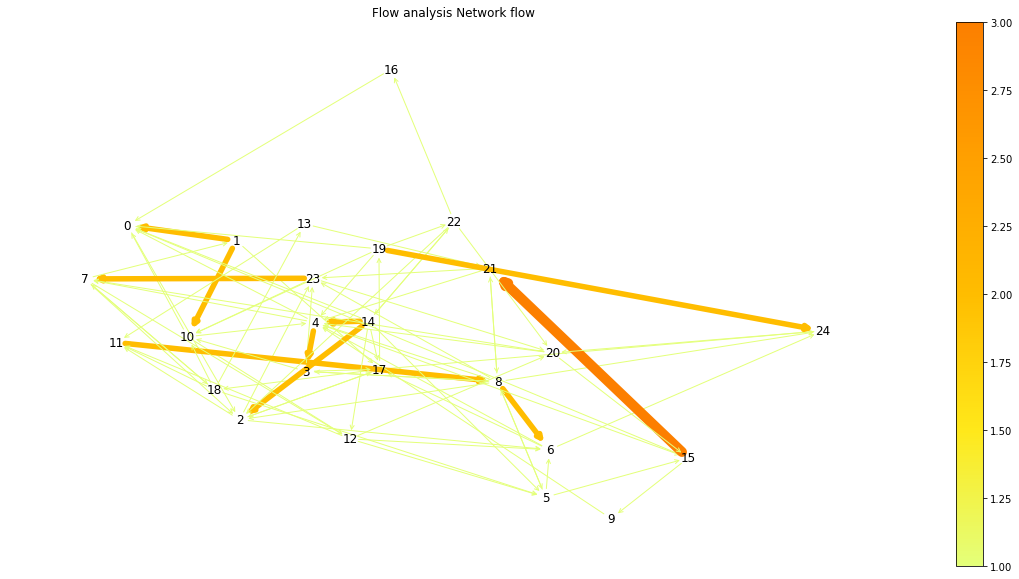

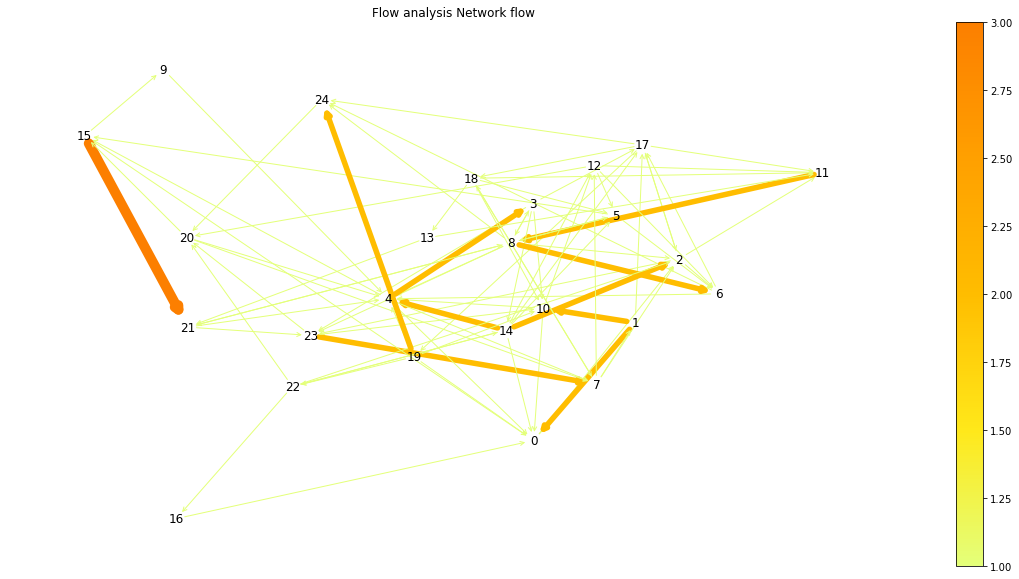

In [24]:
neededcolumns = ['terminalfieldFrom','terminalfieldto','capacityField']

if (all([field in movementColumns.keys() for field in neededcolumns])):
    
    current_path = os.path.join(path_results,f"Network Analysis")
    os.makedirs(current_path, exist_ok=True)
    
    
    #verifico che dati ho a disposizione
    casiDaAnalizzare=[]
    if all([field in timeColumns.keys() for field in ['dischargingpta', 'loadingptd' ]]): 
        casiDaAnalizzare.append('PROVISIONAL')
    if all([field in timeColumns.keys() for field in ['dischargingata','loadingatd' ]]): 
        casiDaAnalizzare.append('ACTUAL')
        
    for actual in casiDaAnalizzare:
        current_path_actual = os.path.join(current_path,f"{actual}")
        os.makedirs(current_path_actual, exist_ok=True)
                
        outputfigure, outptdf = networkStatistics(D_mov,
                                    terminalfieldFrom=movementColumns['terminalfieldFrom'],
                                    terminalfieldto=movementColumns['terminalfieldto'],
                                    capacityField=movementColumns['capacityField'],
                                    
                                    actual=actual,
                                    timeColumns=timeColumns)
        # salvo dataframe
        outptdf.to_excel(current_path_actual+f"\\graphData.xlsx")  
            
        
        #salvo immagini
        for key in outputfigure.keys():
             outputfigure[key].savefig(current_path_actual+f"\\{key}_{actual}_{censored}.png")

## Schedule statistics

**** DEFINE D MOV IN/OUT ****


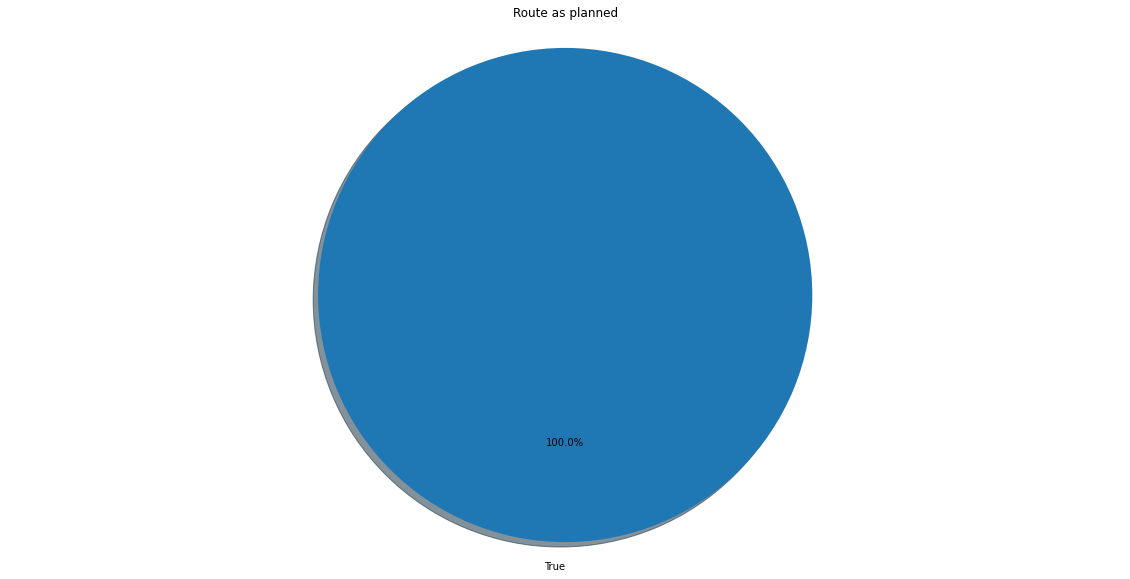

In [25]:
neededcolumns_time= ['loadingpta','loadingptd','dischargingpta','dischargingptd',
                     'loadingata','loadingatd','dischargingata','dischargingatd']
neededcolumns = ['terminalfieldFrom','terminalfieldto','capacityField','voyagefield','vehiclefield']             
if (all([field in movementColumns.keys() for field in neededcolumns]) &
    all([field in timeColumns.keys() for field in neededcolumns_time])): 
    
    current_path = os.path.join(path_results, f"Schedule Analysis")
    os.makedirs(current_path, exist_ok=True)
    output_figure, schedule_results =  checkPlannedActual(D_mov,
                                                          locfrom = movementColumns['terminalfieldFrom'],                    
                                                          locto= movementColumns['terminalfieldto'],
                                                          capacityField=movementColumns['capacityField'],
                                                          voyagefield =movementColumns['voyagefield'],
                                                          vehiclefield=movementColumns['vehiclefield'],
                                                          timeColumns=timeColumns)
    #salvo immagini
    for key in output_figure.keys():
         output_figure[key].savefig(current_path+f"\\{key}.png")
    
    #salvo dataframe
    for key in schedule_results.keys():
         schedule_results[key].to_excel(current_path+f"\\{key}.xlsx")  